# Likelihoods for random SN events

Calculate log-likelihood for a random supernova.  This uses supernovae from the 20 S.M, 10 kpc, no transformation, progenitor file (`progenitors/m20d10kpc.json`) run with Tamborra time limits.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sspike import beer, pnut
from sspike.supernova import Supernova
from sspike.detectors import Detector

## Set detector and progenitor models

Uses same distance and time binning as for simulations.

In [140]:
# Fornax
frn_prog = {'mass': 20.0}
# Kuroda
kur_prog = {"omega": "00", 
            "B0": "00"}
# Nakazato
nak_prog = {'mass': 20,
            'metal': 0.02,
            't_rev': 300}
# Tamborra
tam_prog = {'mass': 20.0}
# Warren
war_prog = {"mass": 20.0,
            "stir": 1.25}

transformation = 'NoTransformation'
distance = 10.0

t_bins = 199
t_start = 0.0065017
t_end = 0.33801

frn = Supernova("Fornax_2021", frn_prog, transformation, distance, t_bins, t_start, t_end)
kur = Supernova("Kuroda_2020", kur_prog, transformation, distance, t_bins, t_start, t_end)
nak = Supernova("Nakazato_2013", nak_prog, transformation, distance, t_bins, t_start, t_end)
tam = Supernova('Tamborra_2014', tam_prog, transformation, distance, t_bins, t_start, t_end)
war = Supernova("Warren_2020", war_prog, transformation, distance, t_bins, t_start, t_end)

kam = Detector('kamland')

## Run simulations

I ran Tamborra separately because of SNEWPY errors for 200 bins. That is why everything is done with 199 bins.  Tamborra notebook time was 1 min 43.7 s (for 199 bins).  This notebook took 6 min 42.2s to run the other 4 models.

In [141]:
for sn in [frn, kur, nak, war]:
    pnut.time_events(sn, kam)

/Users/joe/opt/anaconda3/envs/KLSN/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/Users/joe/opt/anaconda3/envs/KLSN/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/Users/joe/opt/anaconda3/envs/KLSN/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


## Display event rates

Display predicted distributions or generate random events for selected model and channel.

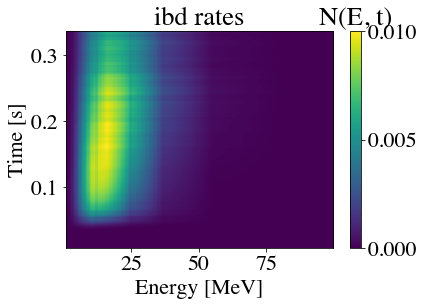

In [156]:
sn = frn
chan = 'ibd'
events = False
beer.plot_N_chan(sn, kam, chan, events=events)

## Total events by model

Load the expected event rate DataFrames for each model and calculate total number expected.

In [145]:
# Predicted rates for each model: N(t, E).
N_frn = pd.read_csv(f"{kam.get_save_dir(frn)}/N_{chan}.csv", sep=" ", index_col=0)
N_kur = pd.read_csv(f"{kam.get_save_dir(kur)}/N_{chan}.csv", sep=" ", index_col=0)
N_nak = pd.read_csv(f"{kam.get_save_dir(nak)}/N_{chan}.csv", sep=" ", index_col=0)
N_tam = pd.read_csv(f"{kam.get_save_dir(tam)}/N_{chan}.csv", sep=" ", index_col=0)
N_war = pd.read_csv(f"{kam.get_save_dir(war)}/N_{chan}.csv", sep=" ", index_col=0)
# Totals by model: N_exp.
N_exp_frn = np.sum(np.sum(N_frn))
N_exp_kur = np.sum(np.sum(N_kur))
N_exp_nak = np.sum(np.sum(N_nak))
N_exp_tam = np.sum(np.sum(N_tam))
N_exp_war = np.sum(np.sum(N_war))

print(f"Expected events for Fornax: {N_exp_frn:.1f}")
print(f"Expected events for Kuroda: {N_exp_kur:.1f}")
print(f"Expected events for Nakazato: {N_exp_nak:.1f}")
print(f"Expected events for Tamborra: {N_exp_tam:.1f}")
print(f"Expected events for Warren: {N_exp_war:.1f}")

Expected events for Fornax: 66.3
Expected events for Kuroda: 55.1
Expected events for Nakazato: 42.6
Expected events for Tamborra: 74.2
Expected events for Warren: 61.1


## Reset indices

I reset the indices before comparison because I have trouble with rounding errors reproducing the SNOwGLoBES energy bins.

In [146]:
rand = frn.random_df()
for df in [N_frn, N_kur, N_nak, N_tam, N_war]:
    df.columns = rand.columns
    df.index = rand.index

## Simulation and comparison

Generate a random set of events for one of the models can calculate the likelihood for all models.

In [147]:
# Limits for plotting
times = N_frn.index.values
energy = pnut.snow_energy()
t0, t1 = times[0], times[-1]
e0, e1 = energy[0] * 1e3, energy[-1] * 1e3

## Log-likelihood function

https://arxiv.org/abs/2101.05269

In [220]:
log_likelihood(N_obs, N_frn)

-32306.603673532725

In [148]:
def log_likelihood(N_obs, N_exp):
    """Calculate log-likelihood for simulated events.
    
    Parameters
    ----------
    N_obs : pd.DataFrame
        DataFrame of randomly generated events.
    N_exp: pd.DataFrame
        DataFrame of predicted event rates.

    Returns
    -------
    ll : float
        Log-likelihood that events in N_obs are from N_exp.
    """
    N_model = np.sum(np.sum(N_exp))
    bins = np.where(N_obs==1)
    ln_bins = np.log(N_exp.iloc[bins])
    sum_ln = np.sum(np.sum(ln_bins))
    ll = sum_ln - N_model
    return ll

def delta_ll(N_obs, N_exp_1, N_exp_2):
    """Calculate log-likelihood for simulated events.
    
    Parameters
    ----------
    N_obs : pd.DataFrame
        DataFrame of randomly generated events.
    N_exp_1: pd.DataFrame
        DataFrame of predicted event rates.
    N_exp_1: pd.DataFrame
        Second DataFrame of predicted event rates.

    Returns
    -------
    dll : float
        Delta-log-likelihood: L1 - L2.
    """
    L1 = log_likelihood(N_obs, N_exp_1)
    L2 = log_likelihood(N_obs, N_exp_2)
    dll = L1 - L2

    return dll

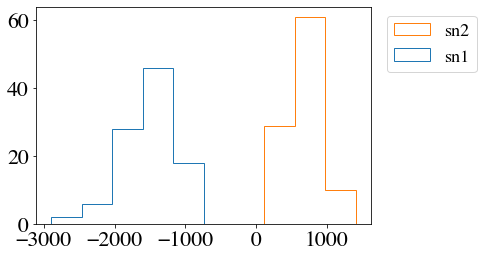

-1518.4630198068976
673.1476387406396


In [224]:
N_sims = 100

sims = [N_kur, N_tam, N_frn]

d_11 = np.empty(N_sims)
d_12 = np.empty(N_sims)
d_13 = np.empty(N_sims)
d_21 = np.empty(N_sims)
d_22 = np.empty(N_sims)
d_23 = np.empty(N_sims)
d_31 = np.empty(N_sims)
d_32 = np.empty(N_sims)
d_33 = np.empty(N_sims)
ds = [[d_11, d_12, d_13], [d_21, d_22, d_23], [d_31, d_32, d_33]]

for i in range(N_sims):
    for j, N_sn in enumerate(sims):
        N_obs = np.where(frn.random_df() > np.exp(-N_sn), 1.0, 0.0)
        for k in range(3):
            ds[k][j][i] = delta_ll(N_obs, sims[k], sims[j])

plt.hist((d_12, d_21), histtype='step', stacked=False, fill=False, label=["sn1", "sn2"])
plt.legend(bbox_to_anchor=(1.02, 1))
plt.show()
print(np.average(d_12))
print(np.average(d_21))

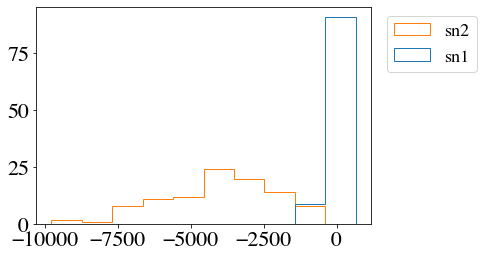

-1518.4630198068976
673.1476387406396


In [226]:
plt.hist((d_23, d_32), histtype='step', stacked=False, fill=False, label=["sn1", "sn2"])
plt.legend(bbox_to_anchor=(1.02, 1))
plt.show()
print(np.average(d_12))
print(np.average(d_21))

In [214]:
# print("Events")
# for n in Ns:
#     print(n)
# print("Deltas")
# for d in ds:
#     print([f"{x:.0f}" for x in d])

1940.1107264780032
265.9642114970407


In [202]:
# Choose distribution for event generation.
N_sn = N_frn
# Lists for log-likelihoods.
models = {'Fornax': [N_frn, []], 
          'Kuroda': [N_kur, []], 
          'Nakazato': [N_nak, []], 
          'Tamborra': [N_tam, []], 
          'Warren': [N_war, []]}
# Number of simulations.
sims = 5
for i in range(sims):
    # Create a random DataFrame of bin probabilities.
    N_rand = sn.random_df()
    # Select bins where random probability is greater than the probability of zero events.
    N_obs = np.where(N_rand > np.exp(-N_sn), 1.0, 0.0)

    for model in models:
        N_exp = models[model][0]
        log_list = models[model][1]
        log_list.append(log_likelihood(N_obs, N_exp))

for model in models:
    print(f"{model}: {models[model][1]}")


Fornax: [-22623.33483663035, -21865.08604215541, -17378.824090566493, -30897.76221054566, -25339.252685080628]
Kuroda: [-23897.4888767025, -22887.166336400984, -18189.220935198136, -32521.135234026668, -26507.471315542665]
Nakazato: [-25012.75992956643, -23885.135696284717, -18995.185208835355, -33639.852155686596, -27435.62666286191]
Tamborra: [-23000.1491108219, -22259.288604111258, -17432.042646174643, -30918.97723416084, -25351.897416739208]
Warren: [-23947.157294167824, -23592.40310232349, -18208.3407295485, -32773.81664175024, -27167.731758576887]


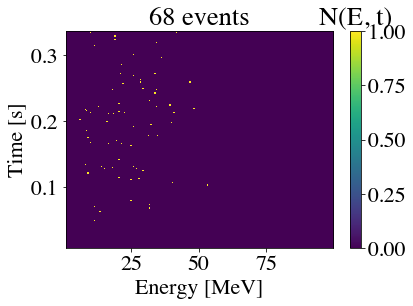

In [203]:
# Display random events
plt.imshow(
        N_obs,
        origin="lower",
        extent=[e0, e1, t0, t1],
        aspect="auto",
        interpolation="none",
    )
plt.title(f"{int(np.sum(np.sum(N_obs)))} events")
plt.xlabel("Energy [MeV]")
plt.ylabel("Time [s]")
clb = plt.colorbar()
clb.ax.set_title("N(E, t)")
plt.show()